# Observational analysis of gender repartition in the cinema
The goal of this study is to observe the gender repartition in the cinema and to try to understand where the inequalities come from.
The observation will be done over the age of the actors, the movies' genre, country and over a certain period of time.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
import ast

In [59]:
# open the files
movie_df = pd.read_csv('movie_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip').drop_duplicates()
char_df=pd.read_csv('character_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip').drop_duplicates()

## Data preprocessesing

In [6]:
# Drop null values in gender column
char_df.dropna(subset='Actor gender', inplace=True)
# Drop bi-gender association for each actor ID in character
bi_gender=char_df.groupby('Freebase actor ID')['Actor gender'].transform('nunique')>1
char_df= char_df[~bi_gender]

In [ ]:
# Select movies with actors we know the genders (common movies between charactere and movie dataframes)
movie_filtered=movie_df[movie_df['Freebase movie ID'].isin(char_df['Freebase movie ID'])]
#print('Number of movies :', movie_filtered['Freebase movie ID'].nunique())

# Associate charactere and movie dataframes on movie ID
char_movie=pd.merge(char_df, movie_filtered, on='Freebase movie ID', how='inner')

# Naïve analysis of gender repartition

The proportion of actresses over the whole population of actors is 36.83%


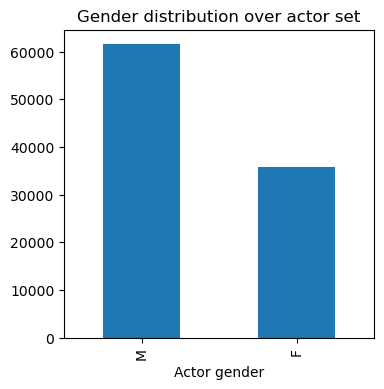

In [96]:
# Proportion of women in the actors data set
#Drop duplicates in actor ID column
gender_actors=char_df[['Freebase actor ID','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
# Count the number of actors
number_actresses=gender_actors[gender_actors['Actor gender']=='F'].count()
proportion_women=number_actresses/gender_actors['Freebase actor ID'].count()

# Print actor gender distribution over actor set
gender_actors["Actor gender"].value_counts().plot(kind='bar', title ='Gender distribution over actor set', figsize=(4,4))

print(f'The proportion of actresses over the whole population of actors is {proportion_women[0]:.2%}')

## Analysis of gender over actor age at movie release

Text(0.5, 1.0, 'Distribution of age repartition over actors')

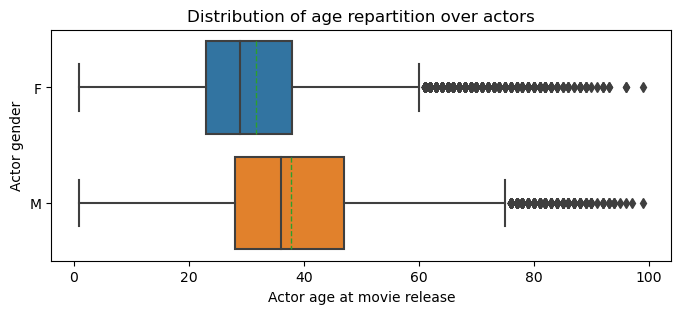

In [99]:
#Drop null values for the age column, drop duplicates in actor ID column
gender_age=char_df[['Freebase actor ID','Actor age at movie release','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
#Drop negative values for age
gender_age['Actor age at movie release']=gender_age['Actor age at movie release'].apply(lambda x: x if x>0 else None).dropna()

# Print distribution of age repartition over actors
plt.figure(figsize=(8,3))
sns.boxplot(y='Actor gender', x='Actor age at movie release', data=gender_age, showmeans=True, meanline=True)
plt.title('Distribution of age repartition over actors')

As we can observe, the average age of the actresses is lower than the average age of the actors. 
Observing the proportion of actressess over the actors population could indicate if this last distribution is not due to a lack of representativeness in the actresses population

The proportion of women is 37.66% in the total actor population. This tells us that the cinema industry is quite unbalance in terms of gender repartition.
What would be interesting now would be to study what are the factors that influence such a disparity.
The following part will try to assess the influence of the time and of the country of the movie on the gender repartition.

## Analysis of gender repartition over movies country

The gender repartition in a movie can be influenced by the culture. 
We decided to select the most common movie country for each continent. This ensure to have the most amount of movies, and to have a wide diversity of cultures.  

In [41]:
#Select most common countries for movies
top_countries=movie_filtered['Countries'].value_counts().head(20).index
print('Top 20 countries :', movie_filtered['Countries'].value_counts().head(20))

Top 10 countries : Countries
['United States of America']                      26042
['India']                                          7414
[]                                                 4939
['United Kingdom']                                 3816
['Japan']                                          1632
['France']                                         1348
['Italy']                                          1166
['Canada']                                          972
['United States of America', 'United Kingdom']      797
['Hong Kong']                                       778
['South Korea']                                     669
['United States of America', 'Canada']              586
['Germany']                                         498
['France', 'Italy']                                 451
['Australia']                                       450
['Spain']                                           388
['Mexico']                                          369
['Argentina']      

According to the very low number of movies for South america, it was decided to take two countries to make sure to have enough samples compared with the other continents. Africa was not taken into account due to its insufficient number of movies. <br/>
The most common movie country for each continent are: <br/>
North america: United States <br/>
Central America: Mexico <br/>
South Americal: Argentina <br/>
Europe: United Kingdoms <br/>
Asia: India <br/>


We are now going to observe the gender distribution in movies over each country

In [60]:
most_common_country=[top_countries[0],top_countries[1],top_countries[3],top_countries[16],top_countries[17]]
#select movies with most common countries
gender_country=char_movie[char_movie['Countries'].isin(most_common_country)][['Freebase actor ID', 'Actor gender','Countries','Freebase movie ID']].dropna()

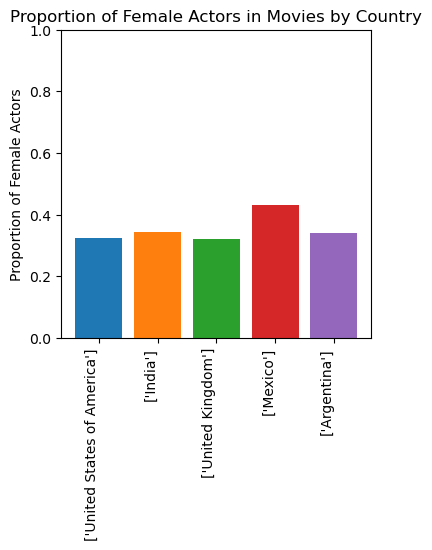

In [101]:
fig, ax = plt.subplots(figsize=(4, 4))

#loop through each country and plot the proportion of female actors
for i, country in enumerate(most_common_country):
    country_data = gender_country[gender_country['Countries'] == country]
    #calculate the proportion of female actors
    total_actors = len(country_data)
    proportion_female = country_data['Actor gender'].value_counts(normalize=True).get('F', 0)
    #plot the proportion of female actors for each country
    ax.bar(i, proportion_female, label=country)

ax.set_xticks(range(len(most_common_country)))
ax.set_xticklabels(most_common_country, rotation=90, ha='right')

ax.set_ylabel('Proportion of Female Actors')
ax.set_ylim(0, 1)

plt.title('Proportion of Female Actors in Movies by Country')
plt.show()

As a conclusion, the gender repartion is also inequal no matter the culture or the continent.
We can observe 

## Analysis of gender repartition over numbers of actors per movie

In [108]:
#find how many actors play in each movie
actor_counts = char_movie.groupby('Freebase movie ID')['Freebase actor ID'].count()
character_counts = char_movie.groupby('Freebase movie ID')['Freebase character ID'].count()
actor_counts.rename('Actor counts', inplace=True)
#percentage of females for each sum of characters in each movie
perc_female = char_movie.groupby('Freebase movie ID')['Actor gender'].apply(lambda x: (x == 'F').sum()/x.count())
fig_df = pd.merge(actor_counts, perc_female, on='Freebase movie ID')

Text(0.5, 1.0, 'Female percentage vs number of actors per movie')

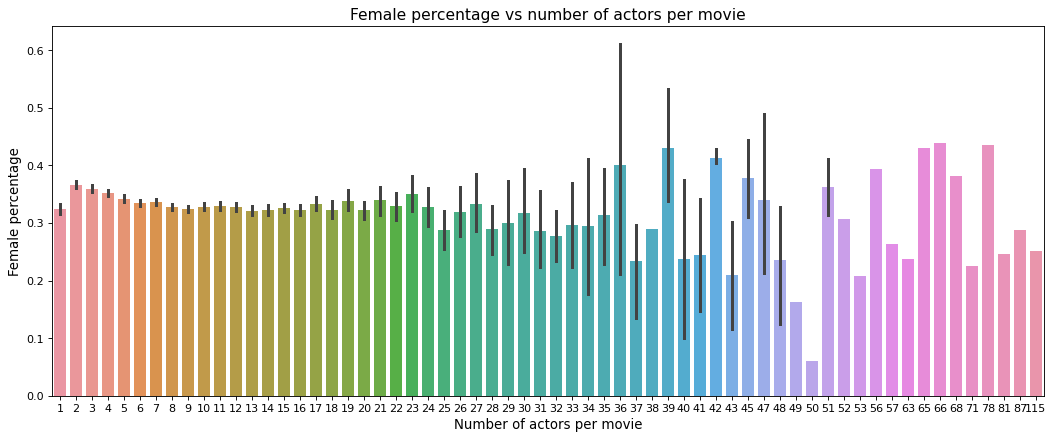

In [112]:
#plot a figure showing the percentage of female actors based on the number of actors in each movie
plt.figure(figsize=(16, 6), dpi=80)
ax = sns.barplot(x="Actor counts", y="Actor gender", data=fig_df)
plt.xlabel('Number of actors per movie', fontsize=12)
plt.ylabel('Female percentage', fontsize= 12)
plt.title('Female percentage vs number of actors per movie', fontsize= 14)

As we increase the number of characters, since the samples are small we see an increase in the confidence intervalls suggesting that the data are unreliable.
Moreover, the percentage of female actors stay more or less the same as the number of actors per movie increases except in the highest value of actors per movie. But as there is no interval of confidence meaning that there is not enough data to be conclusive.

## Analysis of gender repartition over the movie run-time

In [113]:
#Select smaller data frame with only the columns we need
df_runtime = char_movie[['Freebase movie ID','Freebase actor ID', 'Actor gender','Movie runtime']]
#remove rows that have null values in the 'Movie runtime' column
df_runtime.dropna(subset=['Movie runtime'], inplace=True)
#remove 0.1% of the rows with the highest and lowest runtime as they are outliers
df_runtime = df_runtime[df_runtime['Movie runtime'] > df_runtime['Movie runtime'].quantile(0.001)]
df_runtime = df_runtime[df_runtime['Movie runtime'] < df_runtime['Movie runtime'].quantile(0.999)]
#create a df with movie runtimes and the corresponding male and female counts for that runtime
runtime_gender = df_runtime.groupby('Movie runtime').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum())).reset_index()


/var/folders/v5/fpdljqh120ddkxbgv8m1xswr0000gn/T/ipykernel_38730/2817920399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runtime.dropna(subset=['Movie runtime'], inplace=True)


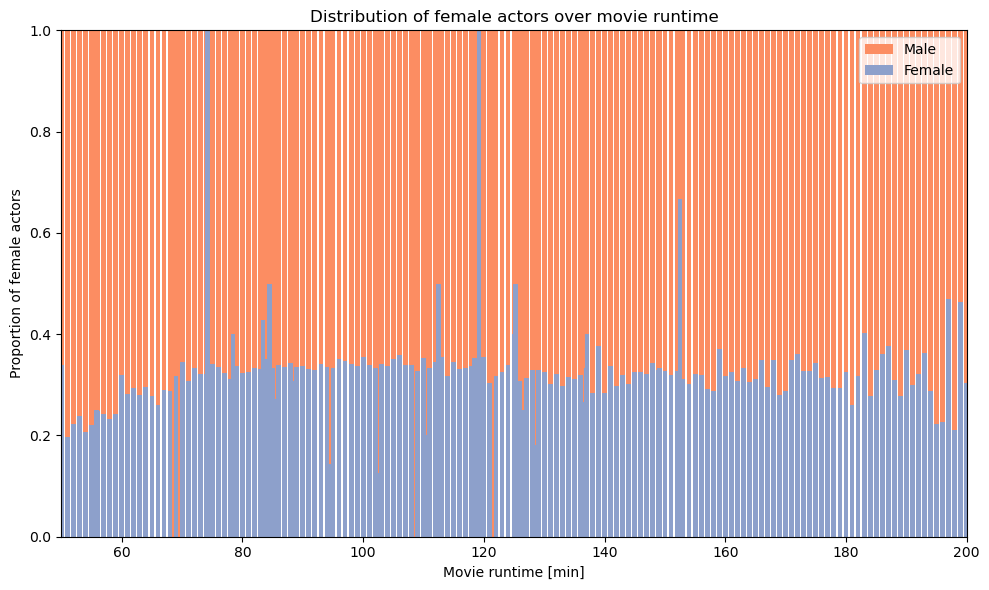

In [118]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Male_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']), 
              label = 'Male', color='#fc8d62', bottom = runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))
bar2 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']) 
              , label = 'Female', color='#8da0cb',)

ax.set_xlabel('Movie runtime [min]')

ax.set_ylabel('Proportion of female actors')
ax.set_title('Distribution of female actors over movie runtime')
ax.set_xbound(lower=50, upper=200)
ax.legend()
plt.tight_layout()
plt.show()

We see the same distribution between male and female actors for different movie runtimes, with females being around half or less than the males as our dataset have generally more males than females. Therefor the factor of the movie runtime does not show much variation of gender repartition.
The spikes that appear are attributed to some outlier data points.

## Analysis of gender repartition over the years

In [137]:
#For each genre create a new subplot
df_year = char_movie.copy()
#change date format for the year only
df_year['Movie release date_x']=pd.to_datetime(df_year['Movie release date_x'], errors='coerce', utc=True)
df_year['Movie release date_x']=df_year['Movie release date_x'].dt.year.dropna().astype(int)
#drop the last years  and the first years as they are not complete
df_year = df_year[(df_year['Movie release date_x'] < 2012)& (df_year['Movie release date_x'] > 1915)]
#df_year['Movie year release']=df_year['Movie release date_x'].dt.year.astype(int)
df_gender_year = df_year.groupby('Movie release date_x').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum()),
                                                         Female_perc = ('Actor gender', lambda x: (x == 'F').sum()/x.count()),
                                                         Male_perc = ('Actor gender', lambda x: (x == 'M').sum()/x.count()),
                                                         Female_means = ('Actor gender', lambda x: (x == 'F').mean()),
                                                         Male_means = ('Actor gender', lambda x: (x == 'M').mean()),
                                                         Female_std = ('Actor gender', lambda x: (x == 'F').std()),
                                                         Male_std = ('Actor gender', lambda x: (x == 'M').std())).reset_index()


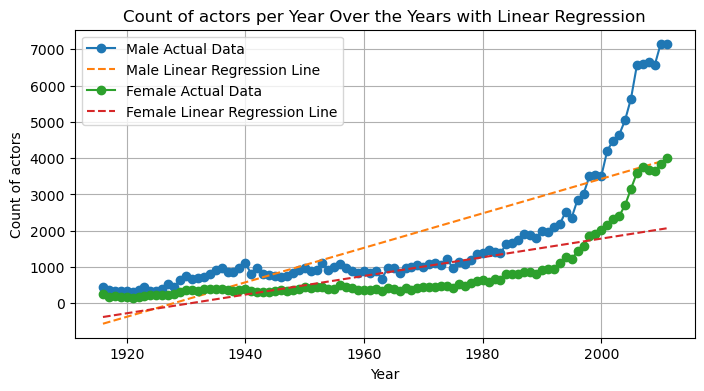

Linear Regression Coefficients for males:
Slope (Coefficient): 47.51
Intercept: -91596.22
R-squared (R²): 0.61
Linear Regression Coefficients for females:
Slope (Coefficient): 25.71
Intercept: -49630.25
R-squared (R²): 0.56
More statistics for males:
F-statistic: 145.84125450356152
p-value: 7.942546527412826e-21
More statistics for females:
F-statistic: 121.59840652538381
p-value: 1.2325865821492985e-18


In [135]:
years = df_gender_year['Movie release date_x'].values.reshape(-1,1)
male_count_year_r = df_gender_year['Male_counts'].values
female_count_year_r = df_gender_year['Female_counts'].values

#linear regression for the count of actors for each year
regression = LinearRegression()
regression.fit(years, male_count_year_r)

regression_f = LinearRegression()
regression_f.fit(years, female_count_year_r)

# Make predictions using the linear model
predicted_character_counts = regression.predict(years)
predicted_character_counts_f = regression_f.predict(years)

plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(years, male_count_year_r, marker='o', linestyle='-', label='Male Actual Data')
plt.plot(years, predicted_character_counts, linestyle='--', label='Male Linear Regression Line')

plt.plot(years, female_count_year_r, marker='o', linestyle='-', label='Female Actual Data')
plt.plot(years, predicted_character_counts_f, linestyle='--', label='Female Linear Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count of actors')
plt.title('Count of actors per Year Over the Years with Linear Regression')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

r_squared = r2_score(male_count_year_r, predicted_character_counts)
r_squared_f = r2_score(female_count_year_r, predicted_character_counts_f)

# Print the linear regression coefficients
print("Linear Regression Coefficients for males:")
print(f"Slope (Coefficient): {regression.coef_[0]:.2f}")
print(f"Intercept: {regression.intercept_:.2f}")
# Print the R-squared value
print(f"R-squared (R²): {r_squared:.2f}")

# Print the linear regression coefficients
print("Linear Regression Coefficients for females:")
print(f"Slope (Coefficient): {regression_f.coef_[0]:.2f}")
print(f"Intercept: {regression_f.intercept_:.2f}")
# Print the R-squared value
print(f"R-squared (R²): {r_squared_f:.2f}")


X_male = sm.add_constant(years)
X_female = sm.add_constant(years)  # Add a constant term for the intercept
model_male = sm.OLS(male_count_year_r, X_male).fit()
model_female = sm.OLS(female_count_year_r, X_female).fit()

print("More statistics for males:")
print("F-statistic:", model_male.fvalue)
print("p-value:", model_male.f_pvalue)

print("More statistics for females:")
print("F-statistic:", model_female.fvalue)
print("p-value:", model_female.f_pvalue)

Only the years between 1915 and 2012 are selected because the other years did not have enough data or were incomplete
We tried to see the trend of the evolution of the actor population per gender over the years with a linear regression. But the evolution of the male and female population of actors over the years getting exponential does not allow to be represented by a line, indeed the R-squared values are only 0.56 for females and 0.61 for males.
However it still allows us to observe that the slope of the male population is higher than the female. Meaning that the population of male actors increased faster over the last decades.

## Analysis of the proportion of actresses over the years
We observed the distribution of the actors per years over the time but let's now observe the evolution of the proportion of the actresses over the years

In [138]:
df_gender_year_old = df_gender_year[df_gender_year['Movie release date_x'] <= 1915]
df_gender_year_new = df_gender_year[df_gender_year['Movie release date_x'] > 1915]
female_counts_1915 = df_gender_year_old['Female_counts'].sum()
female_counts_new = df_gender_year_new['Female_counts'].sum()
print('Percentage of female actors for movies made before 1915', female_counts_1915/female_counts_new*100,'%')

Percentage of female actors for movies made before 1915 0.0 %


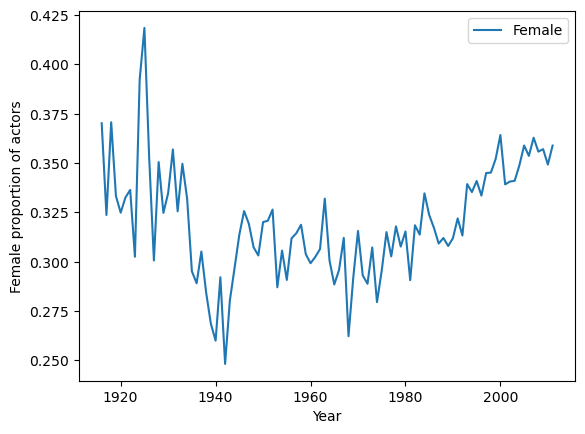

In [139]:
#plotting the percentages of female actors over the years
# Calculate yearly stats across movies here
plt.plot(df_gender_year_new['Movie release date_x'], df_gender_year_new['Female_perc'],
             label = 'Female')
plt.xlabel('Year')
plt.ylabel('Female proportion of actors')
plt.legend()
plt.show()

From this last graph we can see that the evolution of the proportion of female actors has two different trends with a shift around 1940.
It would be interesting for the next steps of the project to study the historical events that influence this evolution and to observe per country how the history has marked the evolution of the place of the women in the cinema